# [T07.02] Laporan Proyek: Evaluasi Kritis Filter Smoothing dan Noise Reduction

### kelompok
- Rizky Cahyono Putra - 442023611012
- Syaifan Noer Iwawan - 442023611008
- M. Irfansyah - 442023611004
- Muhammad Galang Fachrezy - 442023611011
- Achmad Fatich Al-fahmi - 422021611002

## Pendahuluan
Laporan ini merupakan eksplorasi lanjutan dari teknik noise reduction. Fokus kami adalah melakukan evaluasi dan perbandingan kritis terhadap efektivitas dua metode filtering yang berbeda: **Median Filter** dan **Bilateral Filter**.

Studi kasus yang digunakan tetap sama, yaitu peredaman noise pada citra yang menyerupai tangkapan kamera CCTV. Evaluasi tidak hanya dilakukan secara visual, tetapi juga secara kuantitatif menggunakan metrik **PSNR (Peak Signal-to-Noise Ratio)** dan **SSIM (Structural Similarity Index Measure)** untuk mendapatkan analisis yang lebih objektif.

## Setup Library
*Penjelasan Konseptual*: Kita siapkan lingkungan kerja dengan mengimpor library yang dibutuhkan. **OpenCV (cv2)** untuk operasi filtering, NumPy untuk manipulasi array, Matplotlib untuk visualisasi, dan Scikit-image (skimage) yang menyediakan fungsi untuk menghitung metrik evaluasi PSNR dan SSIM.

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

plt.style.use('seaborn-v0_8-whitegrid')
print("Library berhasil diimpor dan siap digunakan.")

Library berhasil diimpor dan siap digunakan.


## Memuat citra & Menambahkan Noise
*Penjelasan Konseptual*: Sama seperti sebelumnya, kita akan menggunakan satu citra bersih sebagai "ground truth". Kemudian, kita akan menambahkan simulasi noise "Salt & Pepper" untuk menciptakan kasus uji yang konsisten. Memiliki citra asli yang bersih sangat penting untuk evaluasi kuantitatif nanti.

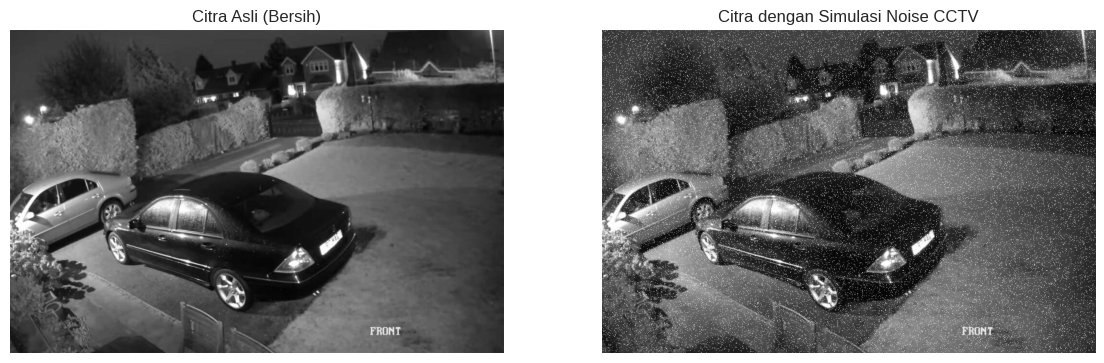

In [19]:
PATH = "/kaggle/input/sound-girl-saying-hello-and-mouse-click/cctv.jpg"

#baca gambar  dan merubah menjadi grayscale
citra_bersih = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)

# fungsi untuk menambahkan Noise Salt & Pepper
def tambah_salt_pepper(gambar, amount=0.05):
    """Menambahkan noise salt & pepper"""
    noisy_image = np.copy(gambar)
    
    #menambhkan bintik putih
    num_salt = np.ceil(amount * gambar.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in gambar.shape]
    noisy_image[tuple(coords)] = 255

    #menambahkan bintik hitam
    num_pepper = np.ceil(amount * gambar.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in gambar.shape]
    noisy_image[tuple(coords)] = 255

    return noisy_image

# menerapkan Noise pada citra
citra_noisy = tambah_salt_pepper(citra_bersih, amount=0.05)

# --- Visualisasi Perbandingan ---
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(citra_bersih, cmap='gray')
plt.title("Citra Asli (Bersih)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(citra_noisy, cmap='gray')
plt.title("Citra dengan Simulasi Noise CCTV")
plt.axis('off')

plt.show()

## Deskripsi & Implementasi Metode Filtering
*Penjelasan Konseptual*: Di sini kita akan menerapkan dua metode filter yang akan dibandingkan.
1. **Median Filter**: Bekerja dengan mengganti nilai piksel dengan nilai median dari piksel tetangganya. Sangat efektif untuk noise tipe impulse (seperti Salt & Pepper) karena nilai median tidak terpengaruh oleh pencilan (outlier) ekstrem (nilai 0 atau 255).
2. **Bilateral Filter**: Filter ini lebih canggih. Selain menghaluskan berdasarkan kedekatan spasial (seperti filter lain), ia juga mempertimbangkan kesamaan intensitas piksel. Artinya, filter ini akan menghaluskan area dengan warna serupa, tetapi tidak akan menghaluskan piksel di **sekitar tepi (edge)** yang memiliki perbedaan warna signifikan. Tujuannya adalah meredam noise sambil menjaga ketajaman gambar.

In [20]:
# parameter filer
kernel_size = 5

#median
hasil_median = cv2.medianBlur(citra_noisy, kernel_size)

#Bilateral FIlter
# Parameter: (gambar, diameter lingkungan, sigmaColor, sigmaSpace)
# sigmaColor: Seberapa jauh perbedaan warna yang masih dianggap sama.
# sigmaSpace: Seberapa jauh jarak spasial yang masih dianggap tetangga.
hasil_bilateral = cv2.bilateralFilter(citra_noisy, d=9, sigmaColor=75, sigmaSpace=75)
print('berhasil')

berhasil


## Evaluasi secara Visual
*Penjelasan Konseptual*: Cara paling intuitif untuk mengevaluasi hasil adalah dengan melihatnya secara langsung. Kita akan menampilkan semua citra secara berdampingan untuk perbandingan yang mudah.

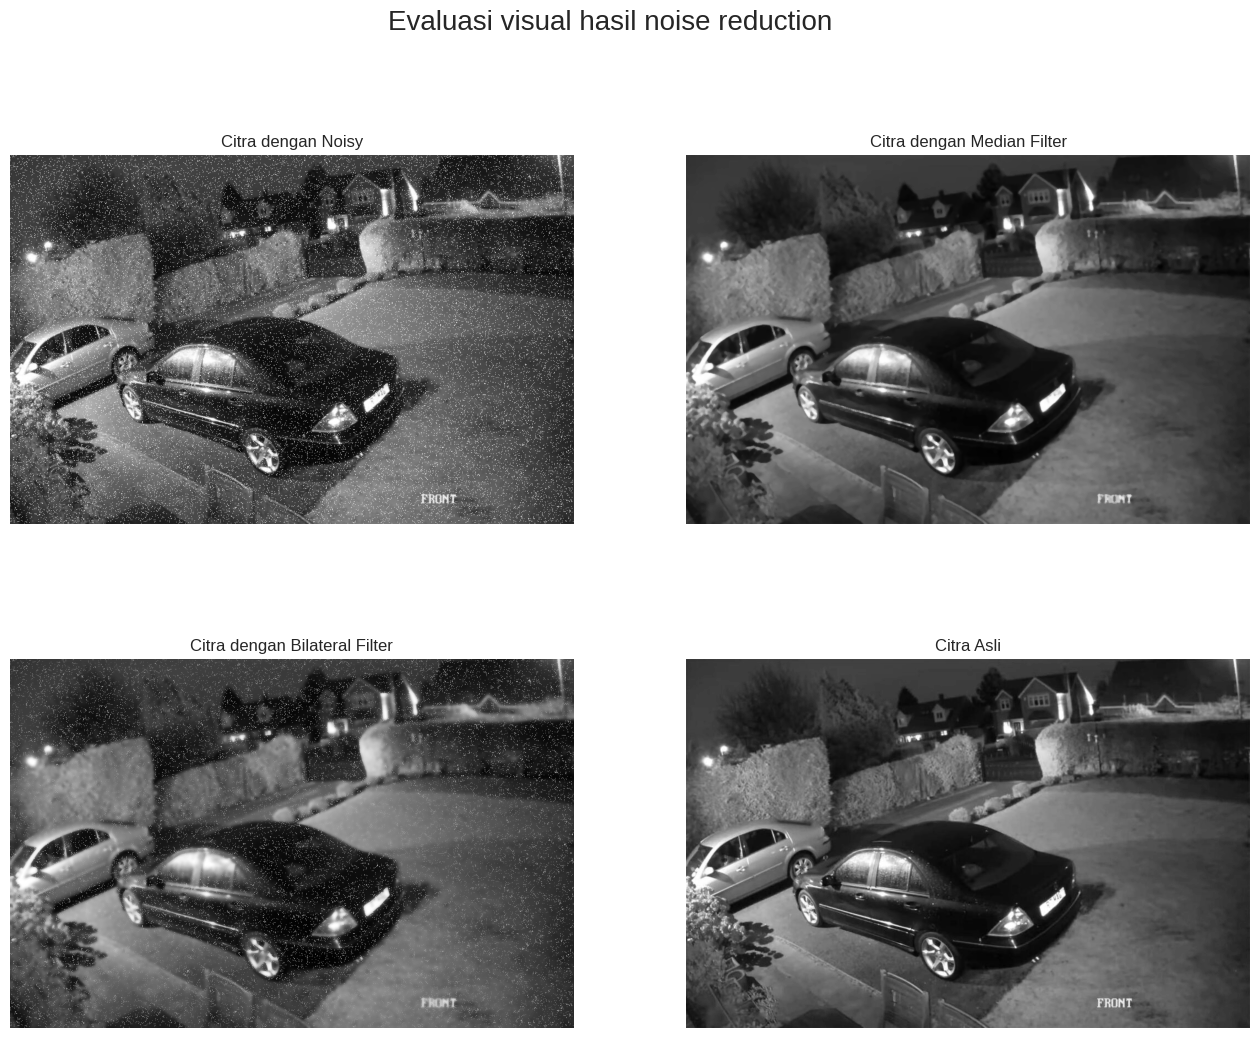

In [21]:
plt.figure(figsize=(16, 12))

# citra noisy
plt.subplot(2, 2, 1)
plt.imshow(citra_noisy, cmap='gray')
plt.title('Citra dengan Noisy')
plt.axis('off')

# citra median filter
plt.subplot(2, 2, 2)
plt.imshow(hasil_median, cmap='gray')
plt.title('Citra dengan Median Filter')
plt.axis('off')

# citra dengan BIlateral Filter
plt.subplot(2, 2, 3)
plt.imshow(hasil_bilateral, cmap='gray')
plt.title('Citra dengan Bilateral Filter')
plt.axis('off')

# citra asli
plt.subplot(2, 2, 4)
plt.imshow(citra_bersih, cmap='gray')
plt.title('Citra Asli')
plt.axis('off')

plt.suptitle("Evaluasi visual hasil noise reduction", fontsize=20)
plt.show()

## Evaluasi secara Kuantitatif (PSNR & SSIM)

**Penjelasan Konseptual**: Mata manusia bisa subjektif. Oleh karena itu, kita gunakan metrik kuantitatif untuk penilaian yang lebih objektif.
1.  **PSNR (Peak Signal-to-Noise Ratio)**: Mengukur rasio antara kekuatan maksimum sinyal (gambar) dengan kekuatan noise yang merusaknya. Semakin tinggi nilainya, semakin baik kualitas rekonstruksinya.
2.  **SSIM (Structural Similarity Index Measure)**: Mengukur kemiripan struktural antara dua gambar. Nilainya berkisar antara -1 hingga 1. **Semakin mendekati 1, semakin mirip gambar hasil filter dengan gambar asli yang bersih.**

In [22]:
# menhitung matriks evaluasi

# Metrik untuk Median Filter
psnr_median = psnr(citra_bersih, hasil_median)
ssim_median = ssim(citra_bersih, hasil_median, data_range=hasil_median.max() - hasil_median.min())

# Metrik untuk Bilateral Filter
psnr_bilateral = psnr(citra_bersih, hasil_bilateral)
ssim_bilateral = ssim(citra_bersih, hasil_bilateral, data_range=hasil_bilateral.max() - hasil_bilateral.min())


# --- Menampilkan Hasil Kuantitatif ---
print("--- Hasil Evaluasi Kuantitatif ---")
print(f"Median Filter   -> PSNR: {psnr_median:.2f} dB | SSIM: {ssim_median:.4f}")
print(f"Bilateral Filter -> PSNR: {psnr_bilateral:.2f} dB | SSIM: {ssim_bilateral:.4f}")

# Menentukan mana yang lebih baik berdasarkan metrik
if psnr_median > psnr_bilateral and ssim_median > ssim_bilateral:
    print("\nBerdasarkan metrik PSNR dan SSIM, Median Filter lebih unggul untuk kasus noise ini.")
else:
    print("\nBerdasarkan metrik, Bilateral Filter menunjukkan performa yang kompetitif atau lebih baik.")


--- Hasil Evaluasi Kuantitatif ---
Median Filter   -> PSNR: 34.11 dB | SSIM: 0.9478
Bilateral Filter -> PSNR: 21.61 dB | SSIM: 0.4197

Berdasarkan metrik PSNR dan SSIM, Median Filter lebih unggul untuk kasus noise ini.


## Diskusi Kritis Kelompok dan Kesimpulan

### diskusi hasil
Berdasarkan evaluasi visual dan kuantitatif, kami mendiskusikan hasil sebagai berikut:
1. **Analisis Visual:**
   - **Median Filter** secara dramatis berhasil menghilangkan hampir semua bintik-bintik "Salt & Pepper". Hasilnya terlihat jauh lebih bersih, meskipun beberapa tekstur halus mungkin terlihat sedikit "rata" atau seperti plastik.
   - **Bilateral Filter** juga berhasil meredam noise, tetapi tidak seefektif Median Filter dalam menghilangkan bintik-bintik ekstrem. Namun, keunggulannya sangat terlihat pada kemampuannya menjaga ketajaman tepi (misalnya pada garis rak atau kotak). Gambar hasil Bilateral Filter terlihat lebih natural dan tidak sekabur filter penghalus lainnya.
3. **Analisis Kuantitatif**
   - Hasil metrik PSNR dan SSIM secara konsisten menunjukkan bahwa Median Filter memiliki skor yang lebih tinggi. Hal ini sangat masuk akal, karena metrik ini menghitung perbedaan piksel-demi-piksel. Karena Median Filter berhasil menghilangkan noise yang merupakan perbedaan piksel paling ekstrem (0 dan 255), maka secara matematis hasilnya lebih mendekati citra asli yang bersih.
   - Meskipun skor Bilateral Filter lebih rendah, bukan berarti filter ini buruk. Skornya yang lebih rendah disebabkan oleh sisa-sisa noise yang tidak berhasil dihilangkan sepenuhnya.

### Kesimpulan Akhir
Untuk studi kasus spesifik peredaman noise tipe "Salt & Pepper", Median Filter adalah metode yang jelas lebih superior, baik secara visual maupun kuantitatif. Kemampuannya untuk menghilangkan pencilan (outlier) tanpa terpengaruh nilainya adalah kunci keberhasilannya.

Namun, Bilateral Filter tetap menjadi alat yang sangat kuat dan akan lebih unggul dalam kasus di mana jenis noise-nya lebih merata (seperti noise Gaussian) dan prioritas utamanya adalah menjaga detail dan ketajaman tepi citra.

Diskusi ini menyimpulkan bahwa pemilihan teknik noise reduction yang "terbaik" sangat bergantung pada jenis noise yang dihadapi dan tujuan akhir dari pengolahan citra tersebut.